<a href="https://colab.research.google.com/github/contatofe/Estudos-e-Desafios/blob/main/PLN%20-%20IA%20Expert/PLN_Arquitetura_Transformer_Tradutor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implementação baseada no paper da arquitetura transformer [Attention is all you need](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)

A proposta é remontar passo a passo a arquitetura da imagem a seguir:

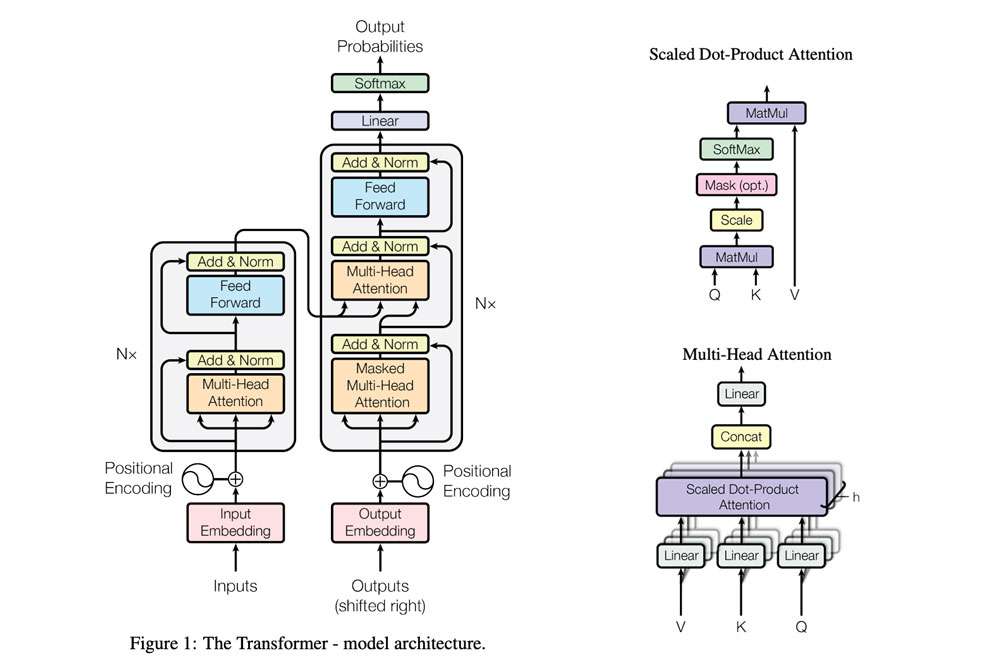

# Etapa 1: Importação das bibliotecas

In [1]:
!pip install tensorflow==2.15 --quiet

In [2]:
import numpy as np
import math
import re
import time
import zipfile
import random
from google.colab import drive
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Etapa 2: Pré-processamento dos dados

## Carregamento da base de dados

- Bases de dados: https://www.statmt.org/europarl/

In [3]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
with open('/content/drive/MyDrive/Arquivos - Dados/Transformer/europarl-v7.pt-en.en', mode='r', encoding='utf-8') as f:
  europarl_en = f.read()
with open('/content/drive/MyDrive/Arquivos - Dados/Transformer/europarl-v7.pt-en.pt', mode='r', encoding='utf-8') as f:
  europarl_pt = f.read ()

## Limpeza dos dados

In [5]:
corpus_en = europarl_en
corpus_en = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])", " ", corpus_en) #Removendo pontos
corpus_en = re.sub(r" +", " ", corpus_en) #Removendo espaçamentos duplos
corpus_en = corpus_en.split('\n') #Quebrando frases

In [6]:
corpus_pt = europarl_pt
corpus_pt = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])", " ", corpus_pt)
corpus_pt = re.sub(r" +", " ", corpus_pt)
corpus_pt = corpus_pt.split('\n')


## Tokenização

In [7]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(corpus_en, target_vocab_size=2**13) #Criando tokenizer com 2ˆ13 palavras

In [8]:
tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(corpus_pt, target_vocab_size=2**13)

In [9]:
vocab_size_en = tokenizer_en.vocab_size + 2 #Criando token de início e final de frase
vocab_size_pt = tokenizer_pt.vocab_size + 2

In [10]:
inputs = [[vocab_size_en - 2] + tokenizer_en.encode(sentence) + [vocab_size_en - 1] for sentence in corpus_en]

In [11]:
outputs = [[vocab_size_pt - 2] + tokenizer_pt.encode(sentence) + [vocab_size_pt - 1] for sentence in corpus_pt]

## Remoção de sentenças muito longas

In [12]:
max_length = 20 # Escolhendo número máximo de palavras nas frases (com foco de diminuir tempo de processamento)
idx_to_remove = [count for count, sent in enumerate(inputs) if len(sent) > max_length] #índices para remover considerando inputs (Inglês)

In [13]:
len(idx_to_remove) #Número de sentenças que saírão do dataset

1457691

In [14]:
for idx in reversed(idx_to_remove):
  del inputs[idx]
  del outputs[idx]

In [15]:
idx_to_remove = [count for count, sent in enumerate(outputs) if len(sent) > max_length] #índices restantes no output (Português)

In [16]:
len(idx_to_remove) #Número de sentenças que saírão do dataset

106663

In [17]:
for idx in reversed(idx_to_remove):
  del inputs[idx]
  del outputs[idx]

## Padding e batches

In [18]:
#Adicionando Padding (preenchendo com 0 frases menores que o tamanho máximo de palavras -> 15 palavras nesse exemplo)
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, value=0, padding = 'post', maxlen=max_length)
outputs = tf.keras.preprocessing.sequence.pad_sequences(outputs, value=0, padding = 'post', maxlen=max_length)

In [19]:
for _ in range(5):
  print(outputs[random.randint(0, len(outputs) - 1)])

[8116 1984    6  899    1    6  327  181 2766   17  408  156 7629  534
 7906 8117    0    0    0    0]
[8116 2226 8117    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
[8116 7932  202    1 1251    1  253  517    4 1569    3 1602 7974 7905
  514 7906 8117    0    0    0]
[8116  905 1556    6  352 7906 8117    0    0    0    0    0    0    0
    0    0    0    0    0    0]
[8116 7929    1  351  169 2520    1    3   40   67   69 3513    8    4
   16 3819 7961 7906 8117    0]


from_tensor_slices: https://www.geeksforgeeks.org/tensorflow-tf-data-dataset-from_tensor_slices/

cache e prefetch: https://www.tensorflow.org/guide/data_performance

In [20]:
#Definindo tamanho do lote (batch) a ser enviado por vez

batch_size = 64
buffer_size = 20000

dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs))
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size).batch(batch_size)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Etapa 3: Construção do modelo

## Embedding

Positional encoding:

$PE_{(pos,2i)} =\sin(pos/10000^{2i/dmodel})$

$PE_{(pos,2i+1)} =\cos(pos/10000^{2i/dmodel})$

- The positional encodings have the same dimension dmodel
as the embeddings, so that the two can be summed

In [21]:
class PositionalEncoding(layers.Layer):

    def __init__(self):
      super(PositionalEncoding, self).__init__()

    def get_angles(self, pos, i, d_model):
      angles = 1 / np.power(10000., (2*(i // 2)) / np.float32(d_model))
      return pos * angles # (seq_lenght, d_model)

    def call(self, inputs):
      seq_lenght = inputs.shape.as_list()[-2]
      d_model = inputs.shape.as_list()[-1]
      angles = self.get_angles(np.arange(seq_lenght)[:, np.newaxis],
                               np.arange(d_model)[np.newaxis, :], d_model)
      angles[:, 0::2] = np.sin(angles[:, 0::2])
      angles[:, 1::2] = np.cos(angles[:, 1::2])
      pos_encoding = angles[np.newaxis, ...]
      return inputs + tf.cast(pos_encoding, tf.float32)

## Mecanismo de atenção

### Cálculo da atenção

$Attention(Q, K, V ) = \text{softmax}\left(\dfrac{QK^T}{\sqrt{d_k}}\right)V $

In [22]:
def scaled_dot_product_attention(queries, keys, values, mask):
  product = tf.matmul(queries, keys, transpose_b=True)
  keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)
  scaled_product = product / tf.math.sqrt(keys_dim)

  if mask is not None:
    scaled_product += (mask * -1e9) # 0.0000000001

  attention = tf.matmul(tf.nn.softmax(scaled_product, axis=-1), values)
  return attention

### Multi-head attention sublayer

In [23]:
class MultiHeadAttention(layers.Layer):

    def __init__(self, nb_proj):
      super(MultiHeadAttention, self).__init__()
      self.nb_proj = nb_proj

    def build(self, input_shape):
      self.d_model = input_shape[-1]
      assert self.d_model % self.nb_proj == 0

      self.d_proj = self.d_model // self.nb_proj

      self.query_lin = layers.Dense(units = self.d_model)
      self.key_lin = layers.Dense(units = self.d_model)
      self.value_lin = layers.Dense(units = self.d_model)

      self.final_lin = layers.Dense(units = self.d_model)

    def split_proj(self, inputs, batch_size): # inputs: (batch_size, seq_lenght, d_model)
      shape = (batch_size, -1, self.nb_proj, self.d_proj)
      splited_inputs = tf.reshape(inputs, shape = shape) # (batch_size, seq_lenght, nb_proj, d_proj)
      return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) # (batch_size, nb_proj, seq_lenght, d_proj)

    def call(self, queries, keys, values, mask):
      batch_size = tf.shape(queries)[0]

      queries = self.query_lin(queries)
      keys = self.key_lin(keys)
      values = self.value_lin(values)

      queries = self.split_proj(queries, batch_size)
      keys = self.split_proj(keys, batch_size)
      values = self.split_proj(values, batch_size)

      attention = scaled_dot_product_attention(queries, keys, values, mask)

      attention = tf.transpose(attention, perm=[0, 2, 1, 3])

      concat_attention = tf.reshape(attention, shape=(batch_size, -1, self.d_model))

      outputs = self.final_lin(concat_attention)

      return outputs

## Encoder

In [24]:
class EncoderLayer(layers.Layer):

    def __init__(self, FFN_units, nb_proj, dropout_rate):
      super(EncoderLayer, self).__init__()
      self.FFN_units = FFN_units
      self.nb_proj = nb_proj
      self.dropout_rate = dropout_rate

    def build(self, input_shape):
      self.d_model = input_shape[-1]

      self.multi_head_attention = MultiHeadAttention(self.nb_proj)
      self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
      self.norm_1 = layers.LayerNormalization(epsilon=1e-6) # 0.0000001

      self.dense_1 = layers.Dense(units=self.FFN_units, activation='relu')
      self.dense_2 = layers.Dense(units=self.d_model, activation='relu')
      self.dropout_2 = layers.Dropout(rate=self.dropout_rate)

      self.norm_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, mask, training):
      attention = self.multi_head_attention(inputs, inputs, inputs, mask)
      attention = self.dropout_1(attention, training = training)
      attention = self.norm_1(attention + inputs)

      outputs = self.dense_1(attention)
      outputs = self.dense_2(outputs)
      outputs = self.dropout_2(outputs, training=training)
      outputs = self.norm_2(outputs + attention)

      return outputs

In [25]:
class Encoder(layers.Layer):

    def __init__(self,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="encoder"):
      super(Encoder, self).__init__(name=name)
      self.nb_layers = nb_layers
      self.d_model = d_model

      self.embedding = layers.Embedding(vocab_size, d_model)
      self.pos_encoding = PositionalEncoding()
      self.dropout = layers.Dropout(rate=dropout_rate)
      self.enc_layers = [EncoderLayer(FFN_units, nb_proj, dropout_rate) for _ in range(nb_layers)]


    def call(self, inputs, mask, training):
      outputs = self.embedding(inputs)
      outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
      outputs = self.pos_encoding(outputs)
      outputs = self.dropout(outputs, training)

      for i in range(self.nb_layers):
        outputs = self.enc_layers[i](outputs, mask, training)

      return outputs

## Decoder

In [26]:
class DecoderLayer(layers.Layer):

    def __init__(self, FFN_units, nb_proj, dropout_rate):
      super(DecoderLayer, self).__init__()
      self.FFN_units = FFN_units
      self.nb_proj = nb_proj
      self.dropout_rate = dropout_rate

    def build(self, input_shape):
      self.d_model = input_shape[-1]

      self.multi_head_attention_1 = MultiHeadAttention(self.nb_proj)
      self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
      self.norm_1 = layers.LayerNormalization(epsilon=1e-6)

      self.multi_head_attention_2 = MultiHeadAttention(self.nb_proj)
      self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
      self.norm_2 = layers.LayerNormalization(epsilon=1e-6)

      self.dense_1 = layers.Dense(units = self.FFN_units, activation='relu')
      self.dense_2 = layers.Dense(units = self.d_model, activation='relu')
      self.dropout_3 = layers.Dropout(rate=self.dropout_rate)
      self.norm_3 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
      attention = self.multi_head_attention_1(inputs, inputs, inputs, mask_1)
      attention = self.dropout_1(attention, training)
      attention = self.norm_1(attention + inputs)

      attention_2 = self.multi_head_attention_2(attention, enc_outputs, enc_outputs, mask_2)
      attention_2 = self.dropout_2(attention_2, training)
      attention_2 = self.norm_2(attention_2 + attention)

      outputs = self.dense_1(attention_2)
      outputs = self.dense_2(outputs)
      outputs = self.dropout_3(outputs, training)
      outputs = self.norm_3(outputs + attention_2)

      return outputs

In [27]:
class Decoder(layers.Layer):

    def __init__(self,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="decoder"):
      super(Decoder, self).__init__(name=name)
      self.d_model = d_model
      self.nb_layers = nb_layers

      self.embedding = layers.Embedding(vocab_size, d_model)
      self.pos_encoding = PositionalEncoding()
      self.dropout = layers.Dropout(rate=dropout_rate)

      self.dec_layers = [DecoderLayer(FFN_units, nb_proj, dropout_rate) for i in range(nb_layers)]

    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
      outputs = self.embedding(inputs)
      outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
      outputs = self.pos_encoding(outputs)
      outputs = self.dropout(outputs, training)

      for i in range(self.nb_layers):
        outputs = self.dec_layers[i](outputs, enc_outputs, mask_1, mask_2, training)

      return outputs

## Transformer

- Matriz triangular: https://mundoeducacao.bol.uol.com.br/matematica/matriz-triangular.htm

In [28]:
class Transformer(tf.keras.Model):

    def __init__(self,
                 vocab_size_enc,
                 vocab_size_dec,
                 d_model,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 name="transformer"):
        super(Transformer, self).__init__(name=name)

        self.encoder = Encoder(nb_layers, FFN_units, nb_proj, dropout_rate,
                               vocab_size_enc, d_model)
        self.decoder = Decoder(nb_layers, FFN_units, nb_proj, dropout_rate,
                               vocab_size_dec, d_model)
        self.last_linear = layers.Dense(units=vocab_size_dec, name='lin_output')

    def create_padding_mask(self, seq): # (batch_size, seq_length) -> (batch_size, nb_proj, seq_lenght, d_proj)
      mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
      return mask[:, tf.newaxis, tf.newaxis, :]

    def create_look_ahead_mask(self, seq):
      seq_len = tf.shape(seq)[1]
      look_ahed_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
      return look_ahed_mask

    def call(self, enc_inputs, dec_inputs, training):
      enc_mask = self.create_padding_mask(enc_inputs)
      dec_mask_1 = tf.maximum(self.create_padding_mask(dec_inputs), self.create_look_ahead_mask(dec_inputs))
      dec_mask_2 = self.create_padding_mask(enc_inputs)

      enc_outputs = self.encoder(enc_inputs, enc_mask, training)
      dec_outputs = self.decoder(dec_inputs, enc_outputs, dec_mask_1, dec_mask_2, training)

      outputs = self.last_linear(dec_outputs)

      return outputs

# Treinamento

In [29]:
tf.keras.backend.clear_session()

d_model = 128 # 512
nb_layers = 4 # 6
ffn_units = 512 # 2048
nb_proj = 8 # 8
dropout_rate = 0.1 # 0.1

In [30]:
transformer = Transformer(vocab_size_enc=vocab_size_en,
                          vocab_size_dec=vocab_size_pt,
                          d_model=d_model,
                          nb_layers=nb_layers,
                          FFN_units=ffn_units,
                          nb_proj=nb_proj,
                          dropout_rate=dropout_rate)

In [31]:
#Desativando função de perda padrão

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')

In [32]:
# Criando função de perda personalizada

def loss_function(target, pred):
  mask = tf.math.logical_not(tf.math.equal(target, 0))
  loss_ = loss_object(target, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [33]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

$lrate =\ d^{−0.5}_{(model)} · min(\ stepnum^{−0.5},\ stepnum · warmupsteps^{−1.5})$

In [34]:
#Criando learning rate personalizado seguindo a formula

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = tf.cast(d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [35]:
learning_rate = CustomSchedule(d_model)

In [36]:
#Criando Otimizador seguindo as recomendações do paper

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [37]:
#Salvando checkpoints de treinamento

checkpoint_path = "/content/drive/MyDrive/Arquivos - Dados/Transformer/Checkpoints"
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

In [ ]:
#Criando treinamento manualmente considerando

epochs = 15
for epoch in range(epochs):
  print('Start or epoch {}'.format(epoch + 1))
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  for (batch, (enc_inputs, targets)) in enumerate(dataset):
    dec_inputs = targets[:, :-1]
    dec_outputs_real = targets[:, 1:]
    with tf.GradientTape() as tape:
      predictions = transformer(enc_inputs, dec_inputs, True)
      loss = loss_function(dec_outputs_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(dec_outputs_real, predictions)

    if batch % 3250 == 0:
      print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch+1, train_loss.result(), train_accuracy.result()))

  ckpt_save_path = ckpt_manager.save()
  print('Saving checkpoint for epoch {} at {}'.format(epoch + 1, ckpt_save_path))
  print('Time taken for 1 epoch {} secs\n'.format(time.time() - start))

Start or epoch 1
Epoch 1 Loss 6.2492 Accuracy 0.0008
Epoch 1 Loss 3.3060 Accuracy 0.2004


# Avaliação

In [ ]:
def evaluate(inp_sentence):
  inp_sentence = [vocab_size_en - 2] + tokenizer_en.encode(inp_sentence) + [vocab_size_en - 1]
  enc_input = tf.expand_dims(inp_sentence, axis=0)

  output = tf.expand_dims([vocab_size_pt - 2], axis = 0)

  for _ in range(max_length):
    # (1, seq_length, vocab_size)
    predictions = transformer(enc_input, output, False)
    prediction = predictions[:, -1:, :]

    predicted_id = tf.cast(tf.argmax(prediction, axis=-1), tf.int32)

    if predicted_id == vocab_size_pt - 1:
      return tf.squeeze(output, axis=0)

    output = tf.concat([output, predicted_id], axis=1)

  return tf.squeeze(output, axis = 0)

In [ ]:
def translate(sentence):
  output = evaluate(sentence).numpy()

  predicted_sentence = tokenizer_pt.decode([i for i in output if i < vocab_size_pt - 2])

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))


In [ ]:
translate("this is a really powerful tool")

##Para melhorar o modelo:

1. Utilizar a base de dados completa

2. Aumentar o tamanho da frase

3. Mudar os parâmetros